# 01 — EDA: IBM Telco Customer Churn (Model 3)

**Dataset:** IBM Sample Data — Telco Customer Churn  
**Source:** [Kaggle / IBM Watson Analytics](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
**Rows:** 7,043 customers · **Columns:** 21  
**Target:** `Churn` (Yes / No → 1 / 0) · **Positive rate:** ~26.5%  
**Date:** 2026-02-23

**Intent:** Orient to the dataset, confirm data quality, and produce a suite of charts that justify the feature choices used downstream in `src/feature_engineering.py` (contract type, tenure, monthly charges, internet service, payment method, and the engineered `num_services` bundle count).

**Sections:**
1. Raw Data Load
2. Target Distribution
3. Churn by Contract Type
4. Churn by Tenure
5. Churn by MonthlyCharges
6. Churn by Internet Service
7. Payment Method Analysis
8. Service Bundle Analysis
9. Correlation Heatmap
10. Summary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ---------------------------------------------------------------------------
# Paths — resolve relative to this notebook's location
# ---------------------------------------------------------------------------
PROJECT_ROOT = Path('__file__').resolve().parent.parent  # m03_churn/
# Use absolute paths so the notebook runs from any working directory
PROJECT_ROOT = Path('/Users/aayan/MarketingAnalytics/m03_churn')
RAW_DIR      = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'

CSV_PATH      = RAW_DIR / 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
CLEAN_PARQUET = PROCESSED_DIR / 'customers_clean.parquet'

print(f'Project root : {PROJECT_ROOT}')
print(f'CSV path     : {CSV_PATH}  exists={CSV_PATH.exists()}')
print(f'Parquet path : {CLEAN_PARQUET}  exists={CLEAN_PARQUET.exists()}')

# ---------------------------------------------------------------------------
# Shared plot style
# ---------------------------------------------------------------------------
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})
CHURN_COLORS = {'No': 'steelblue', 'Yes': 'tomato'}

Project root : /Users/aayan/MarketingAnalytics/m03_churn
CSV path     : /Users/aayan/MarketingAnalytics/m03_churn/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv  exists=True
Parquet path : /Users/aayan/MarketingAnalytics/m03_churn/data/processed/customers_clean.parquet  exists=True


## 1. Raw Data Load

**Intent:** Read the raw CSV into a DataFrame, inspect the schema, check for the known blank `TotalCharges` values (11 new customers with zero tenure), and confirm row/column counts match the documented 7,043 × 21 shape.

In [2]:
# Load raw CSV — TotalCharges arrives as object dtype because of blank strings
df = pd.read_csv(CSV_PATH)

print(f'Shape: {df.shape}')
print(f'Columns ({len(df.columns)}): {df.columns.tolist()}')

Shape: (7043, 21)
Columns (21): ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [3]:
# --- Schema / dtypes ---
print('=== DTYPES ===')
print(df.dtypes.to_frame('dtype').to_string())

=== DTYPES ===
                    dtype
customerID            str
gender                str
SeniorCitizen       int64
Partner               str
Dependents            str
tenure              int64
PhoneService          str
MultipleLines         str
InternetService       str
OnlineSecurity        str
OnlineBackup          str
DeviceProtection      str
TechSupport           str
StreamingTV           str
StreamingMovies       str
Contract              str
PaperlessBilling      str
PaymentMethod         str
MonthlyCharges    float64
TotalCharges          str
Churn                 str


In [4]:
# --- Check TotalCharges blanks ---
# IBM documented that 11 customers have blank TotalCharges (tenure == 0, new sign-ups)
tc_blanks = df[df['TotalCharges'].str.strip() == ''].copy()
print(f'Blank TotalCharges rows: {len(tc_blanks)}')
print(tc_blanks[['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']])

# Coerce TotalCharges to numeric (blanks → NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f'\nNull TotalCharges after coerce: {df["TotalCharges"].isna().sum()}')

Blank TotalCharges rows: 2
      customerID  tenure  MonthlyCharges TotalCharges Churn
2331  1985-KBCBD       0           79.38                 No
2976  4794-TG15X       0           77.36                 No

Null TotalCharges after coerce: 2


In [5]:
# --- Overall null counts ---
print('=== NULL COUNTS ===')
null_summary = df.isnull().sum().to_frame('null_count')
null_summary['null_pct'] = (null_summary['null_count'] / len(df) * 100).round(2)
print(null_summary[null_summary['null_count'] > 0])

print(f'\nDuplicate rows: {df.duplicated().sum()}')

=== NULL COUNTS ===
              null_count  null_pct
TotalCharges           2      0.03

Duplicate rows: 0


In [6]:
# Preview first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,9219-GI809,Female,0,Yes,Yes,51,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,Month-to-month,No,Electronic check,86.35,4385.21,Yes
1,4216-R0UI1,Male,1,Yes,No,11,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,No,Two year,No,Bank transfer (automatic),49.26,544.42,No
2,8532-0PLED,Female,1,No,No,41,No,No phone service,Fiber optic,No,...,No,Yes,No,Yes,Month-to-month,No,Bank transfer (automatic),71.36,2917.04,No
3,7476-9CCWE,Female,0,Yes,No,29,No,No phone service,DSL,No,...,No,Yes,Yes,Yes,Two year,No,Electronic check,48.31,1402.16,No
4,4161-W29PH,Male,0,No,No,13,Yes,No,DSL,No,...,Yes,No,Yes,No,One year,No,Credit card (automatic),18.25,254.21,No


In [7]:
# --- Numeric summary ---
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe().round(2)

,tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7041.00
mean,28.63,58.08,1659.69
std,14.45,22.42,1097.49
min,0.00,18.25,24.03
25%,17.00,41.94,804.63
50%,27.00,58.65,1431.36
75%,39.00,74.55,2289.15
max,71.00,118.75,6915.27


## 2. Target Distribution

**Intent:** Quantify class imbalance on the `Churn` target. At ~26.5% positive rate the dataset is moderately imbalanced — significant enough to warrant precision-recall tracking during modeling, but not extreme enough to require aggressive resampling.

In [8]:
# --- Class imbalance table ---
churn_counts = df['Churn'].value_counts()
churn_pcts   = df['Churn'].value_counts(normalize=True).mul(100).round(2)

imbalance_df = pd.DataFrame({
    'Count': churn_counts,
    'Percentage': churn_pcts,
})
print('=== CHURN CLASS DISTRIBUTION ===')
print(imbalance_df)
print(f'\nImbalance ratio (No:Yes): {churn_counts["No"]/churn_counts["Yes"]:.2f}:1')

=== CHURN CLASS DISTRIBUTION ===
       Count  Percentage
Churn                   
No      5165       73.34
Yes     1878       26.66

Imbalance ratio (No:Yes): 2.75:1


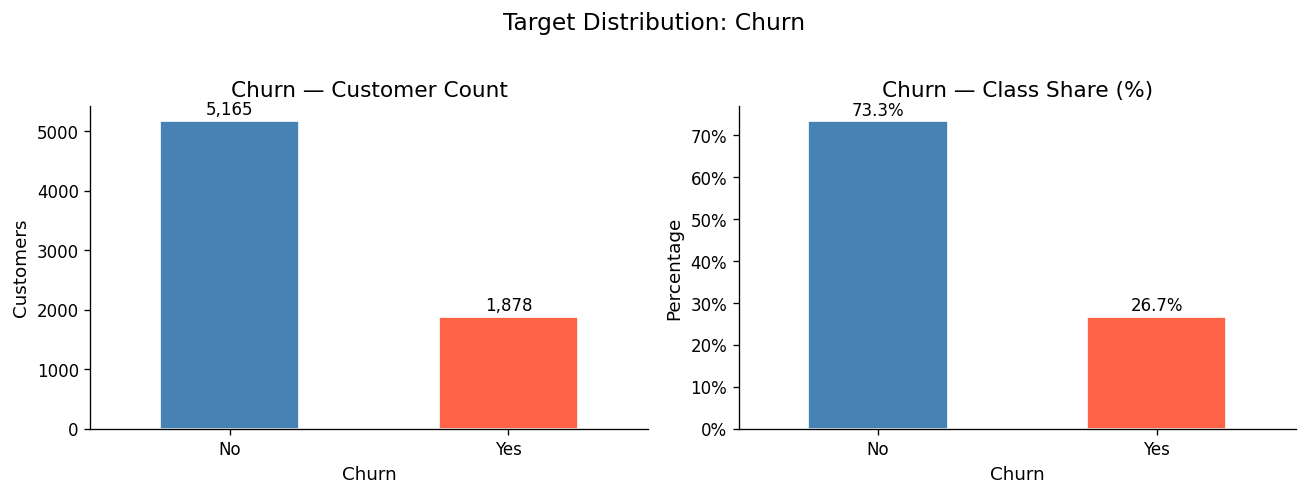

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Left: raw count bar chart
colors = [CHURN_COLORS[v] for v in churn_counts.index]
churn_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='white', width=0.5)
axes[0].set_title('Churn — Customer Count')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Customers')
axes[0].tick_params(axis='x', rotation=0)
for bar, val in zip(axes[0].patches, churn_counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{val:,}', ha='center', va='bottom', fontsize=10)

# Right: percentage bar chart
churn_pcts.plot(kind='bar', ax=axes[1], color=colors, edgecolor='white', width=0.5)
axes[1].set_title('Churn — Class Share (%)')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Percentage')
axes[1].tick_params(axis='x', rotation=0)
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter())
for bar, val in zip(axes[1].patches, churn_pcts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

plt.suptitle('Target Distribution: Churn', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Churn by Contract Type

**Intent:** Contract type is the single strongest predictor of churn in this dataset. Month-to-month customers churn at ~42%, compared to ~11% for one-year and ~3% for two-year contracts. This chart motivates the three one-hot columns (`Contract_Month-to-month`, `Contract_One year`, `Contract_Two year`) and the `is_month_to_month` engineered flag in `feature_engineering.py`.

In [10]:
# Compute churn rate and counts per contract type
contract_stats = (
    df.groupby('Contract')['Churn']
    .value_counts(normalize=False)
    .unstack(fill_value=0)
)
contract_stats['total']     = contract_stats.sum(axis=1)
contract_stats['churn_rate'] = contract_stats['Yes'] / contract_stats['total'] * 100

print('=== CHURN RATE BY CONTRACT TYPE ===')
print(contract_stats[['No', 'Yes', 'total', 'churn_rate']].round(2))

=== CHURN RATE BY CONTRACT TYPE ===
Churn             No   Yes  total  churn_rate
Contract                                     
Month-to-month  2286  1595   3881       41.10
One year        1255   204   1459       13.98
Two year        1624    79   1703        4.64


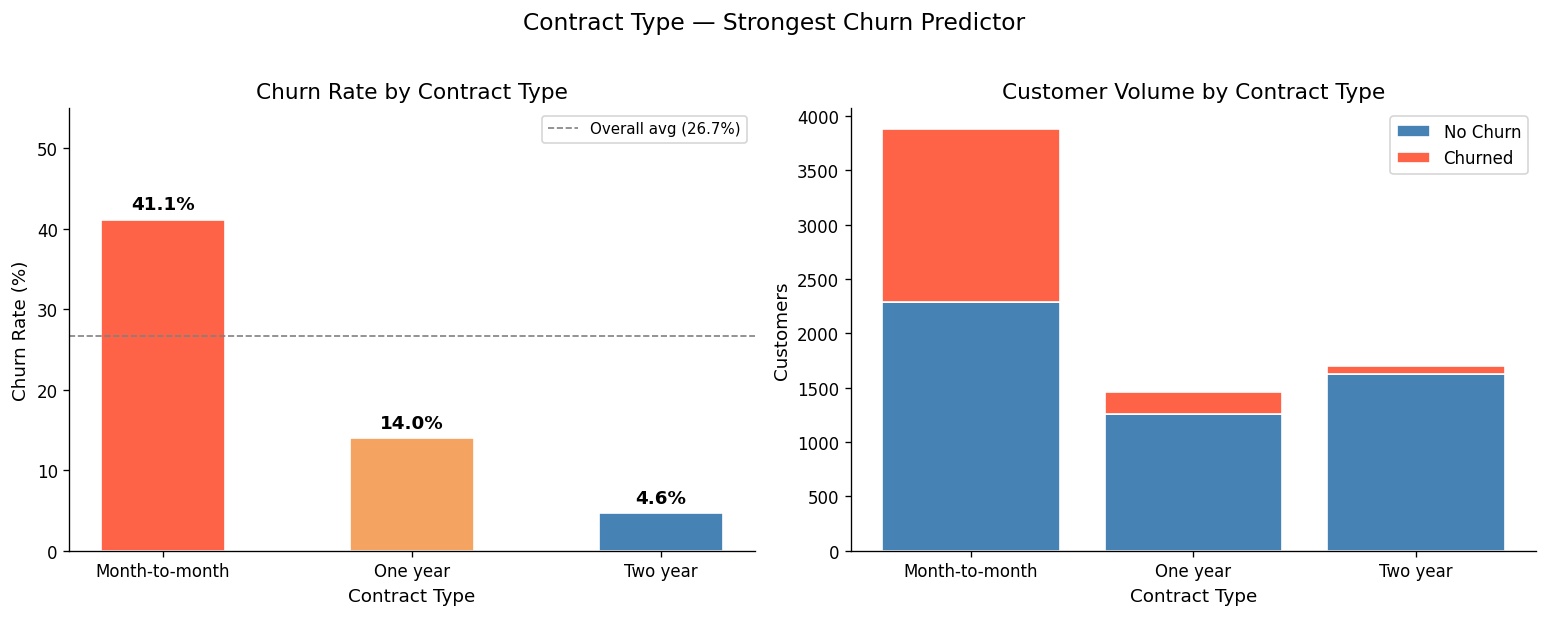

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: churn rate bar chart
contract_order = ['Month-to-month', 'One year', 'Two year']
rates = contract_stats.loc[contract_order, 'churn_rate']
bar_colors = ['tomato', 'sandybrown', 'steelblue']
bars = axes[0].bar(contract_order, rates, color=bar_colors, edgecolor='white', width=0.5)
axes[0].set_title('Churn Rate by Contract Type')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_ylim(0, 55)
axes[0].axhline(df['Churn'].eq('Yes').mean() * 100, color='grey', linestyle='--',
                linewidth=1, label=f'Overall avg ({df["Churn"].eq("Yes").mean()*100:.1f}%)')
axes[0].legend(fontsize=9)
for bar, val in zip(bars, rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Right: stacked count chart (shows absolute volume at each contract tier)
bottom_vals = contract_stats.loc[contract_order, 'No'].values
top_vals    = contract_stats.loc[contract_order, 'Yes'].values
x = range(len(contract_order))
axes[1].bar(x, bottom_vals, color='steelblue', edgecolor='white', label='No Churn')
axes[1].bar(x, top_vals, bottom=bottom_vals, color='tomato', edgecolor='white', label='Churned')
axes[1].set_xticks(list(x))
axes[1].set_xticklabels(contract_order)
axes[1].set_title('Customer Volume by Contract Type')
axes[1].set_xlabel('Contract Type')
axes[1].set_ylabel('Customers')
axes[1].legend()

plt.suptitle('Contract Type — Strongest Churn Predictor', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Churn by Tenure

**Intent:** Tenure (months with the company) is the second strongest raw predictor. Churners are heavily concentrated in the first 12 months; long-tenured customers are substantially less likely to leave. This motivates keeping `tenure` as a direct feature and the `monthly_per_tenure` ratio engineered in `feature_engineering.py`.

In [12]:
# Mean tenure per churn group
tenure_by_churn = df.groupby('Churn')['tenure'].agg(['mean', 'median', 'std']).round(2)
print('=== TENURE STATISTICS BY CHURN GROUP ===')
print(tenure_by_churn)

=== TENURE STATISTICS BY CHURN GROUP ===
        mean  median    std
Churn                      
No     29.76    29.0  14.58
Yes    25.51    24.0  13.61


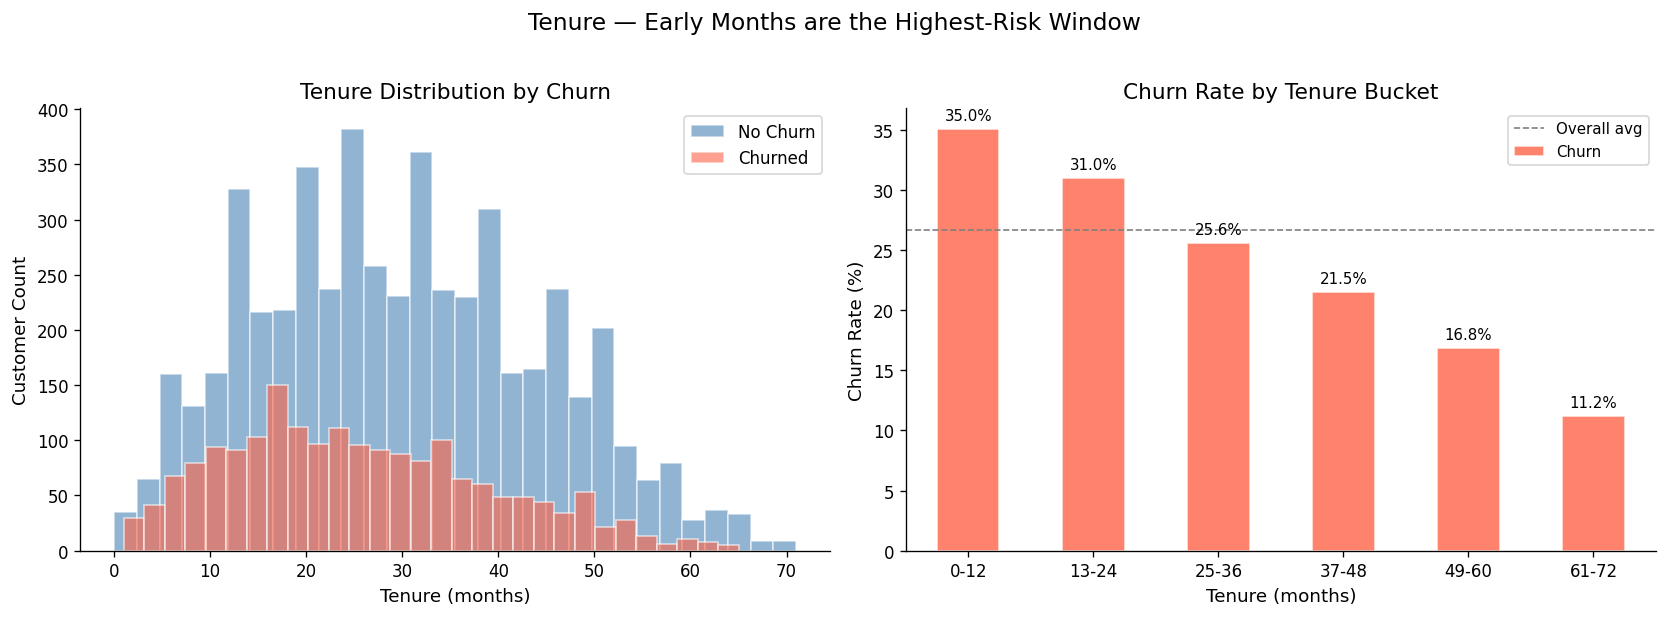

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: overlapping histograms of tenure by churn group
for churn_val, color, label in [('No', 'steelblue', 'No Churn'), ('Yes', 'tomato', 'Churned')]:
    axes[0].hist(
        df.loc[df['Churn'] == churn_val, 'tenure'],
        bins=30, alpha=0.6, color=color, label=label, edgecolor='white'
    )
axes[0].set_title('Tenure Distribution by Churn')
axes[0].set_xlabel('Tenure (months)')
axes[0].set_ylabel('Customer Count')
axes[0].legend()

# Right: churn rate in 12-month tenure buckets
df['tenure_bucket'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 36, 48, 60, 72],
    labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'],
    right=True, include_lowest=True
)
bucket_rates = (
    df.groupby('tenure_bucket', observed=True)['Churn']
    .apply(lambda x: (x == 'Yes').mean() * 100)
)
bucket_rates.plot(kind='bar', ax=axes[1], color='tomato', edgecolor='white', alpha=0.8)
axes[1].set_title('Churn Rate by Tenure Bucket')
axes[1].set_xlabel('Tenure (months)')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].tick_params(axis='x', rotation=0)
axes[1].axhline(df['Churn'].eq('Yes').mean() * 100, color='grey', linestyle='--',
                linewidth=1, label='Overall avg')
axes[1].legend(fontsize=9)
for bar, val in zip(axes[1].patches, bucket_rates):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.suptitle('Tenure — Early Months are the Highest-Risk Window', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Clean up helper column
df.drop(columns=['tenure_bucket'], inplace=True)

## 5. Churn by MonthlyCharges

**Intent:** Higher monthly charges correlate with higher churn — churners pay a median of ~$79/month vs ~$61 for retained customers. A boxplot and density overlay show both the central tendency difference and the distribution overlap, which motivates keeping `MonthlyCharges` as a direct feature alongside the `monthly_per_tenure` ratio.

In [14]:
# Summary statistics for MonthlyCharges by churn group
mc_stats = df.groupby('Churn')['MonthlyCharges'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
print('=== MONTHLY CHARGES STATISTICS BY CHURN GROUP ===')
print(mc_stats)

=== MONTHLY CHARGES STATISTICS BY CHURN GROUP ===
        mean  median    std    min     max
Churn                                     
No     54.94   54.90  22.28  18.25  118.75
Yes    66.70   68.18  20.45  18.25  118.75


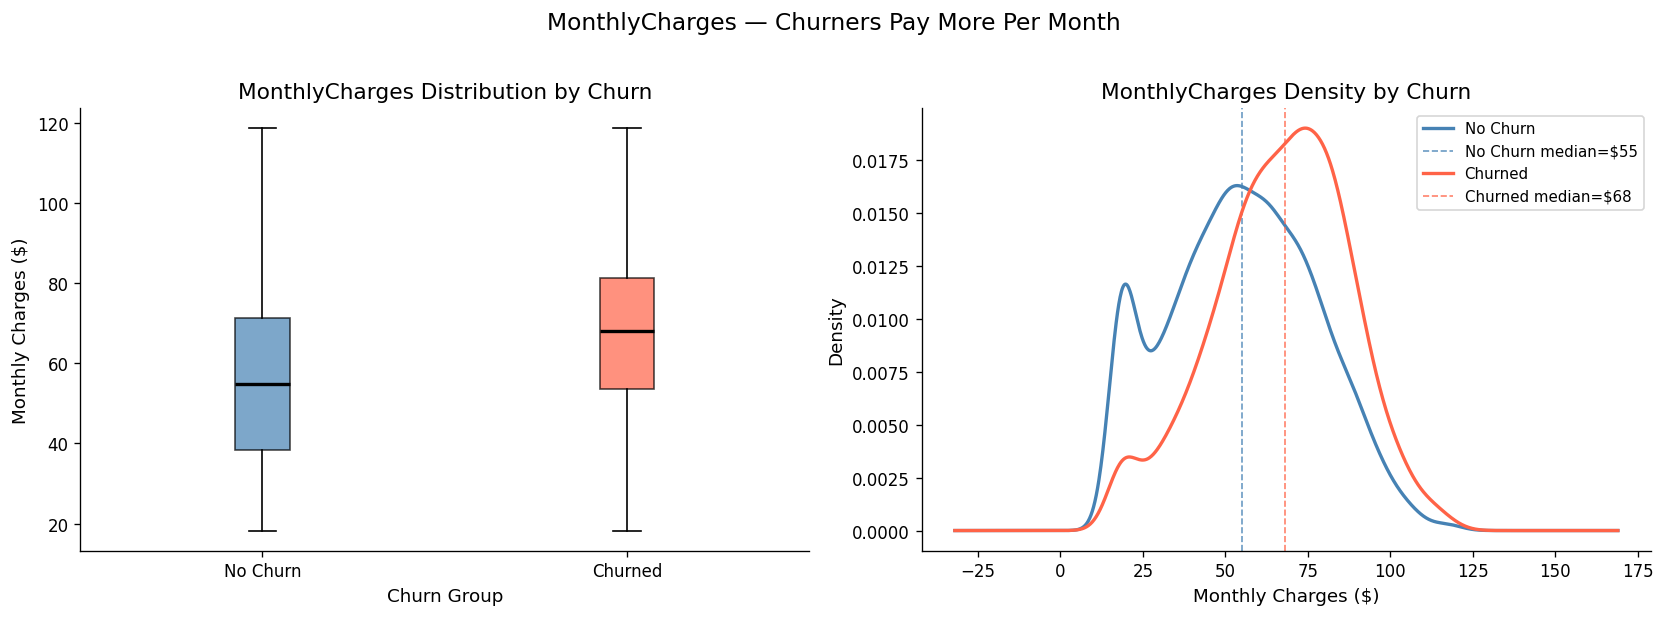

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: boxplot of MonthlyCharges by Churn group
churn_order = ['No', 'Yes']
plot_data   = [df.loc[df['Churn'] == g, 'MonthlyCharges'] for g in churn_order]
bp = axes[0].boxplot(
    plot_data, labels=['No Churn', 'Churned'],
    patch_artist=True, notch=False,
    medianprops=dict(color='black', linewidth=2)
)
for patch, color in zip(bp['boxes'], ['steelblue', 'tomato']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_title('MonthlyCharges Distribution by Churn')
axes[0].set_xlabel('Churn Group')
axes[0].set_ylabel('Monthly Charges ($)')

# Right: KDE density plot
for churn_val, color, label in [('No', 'steelblue', 'No Churn'), ('Yes', 'tomato', 'Churned')]:
    data = df.loc[df['Churn'] == churn_val, 'MonthlyCharges']
    data.plot.kde(ax=axes[1], color=color, label=label, linewidth=2)
    axes[1].axvline(data.median(), color=color, linestyle='--', linewidth=1,
                    alpha=0.8, label=f'{label} median=${data.median():.0f}')
axes[1].set_title('MonthlyCharges Density by Churn')
axes[1].set_xlabel('Monthly Charges ($)')
axes[1].set_ylabel('Density')
axes[1].legend(fontsize=9)

plt.suptitle('MonthlyCharges — Churners Pay More Per Month', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Churn by Internet Service

**Intent:** Internet service type shows a stark three-way split: Fiber optic customers churn at ~41%, DSL at ~19%, and customers with no internet service at ~8%. Fiber optic's premium price point likely drives dissatisfaction, making `InternetService` a critical categorical feature and the `is_fiber_optic` flag a high-signal engineered predictor.

In [16]:
# Churn rate and customer count per internet service tier
inet_stats = (
    df.groupby('InternetService')['Churn']
    .value_counts(normalize=False)
    .unstack(fill_value=0)
)
inet_stats['total']      = inet_stats.sum(axis=1)
inet_stats['churn_rate'] = inet_stats['Yes'] / inet_stats['total'] * 100

print('=== CHURN RATE BY INTERNET SERVICE ===')
print(inet_stats[['No', 'Yes', 'total', 'churn_rate']].round(2))

=== CHURN RATE BY INTERNET SERVICE ===
Churn              No   Yes  total  churn_rate
InternetService                               
DSL              2453   610   3063       19.92
Fiber optic      1900  1196   3096       38.63
No                812    72    884        8.14


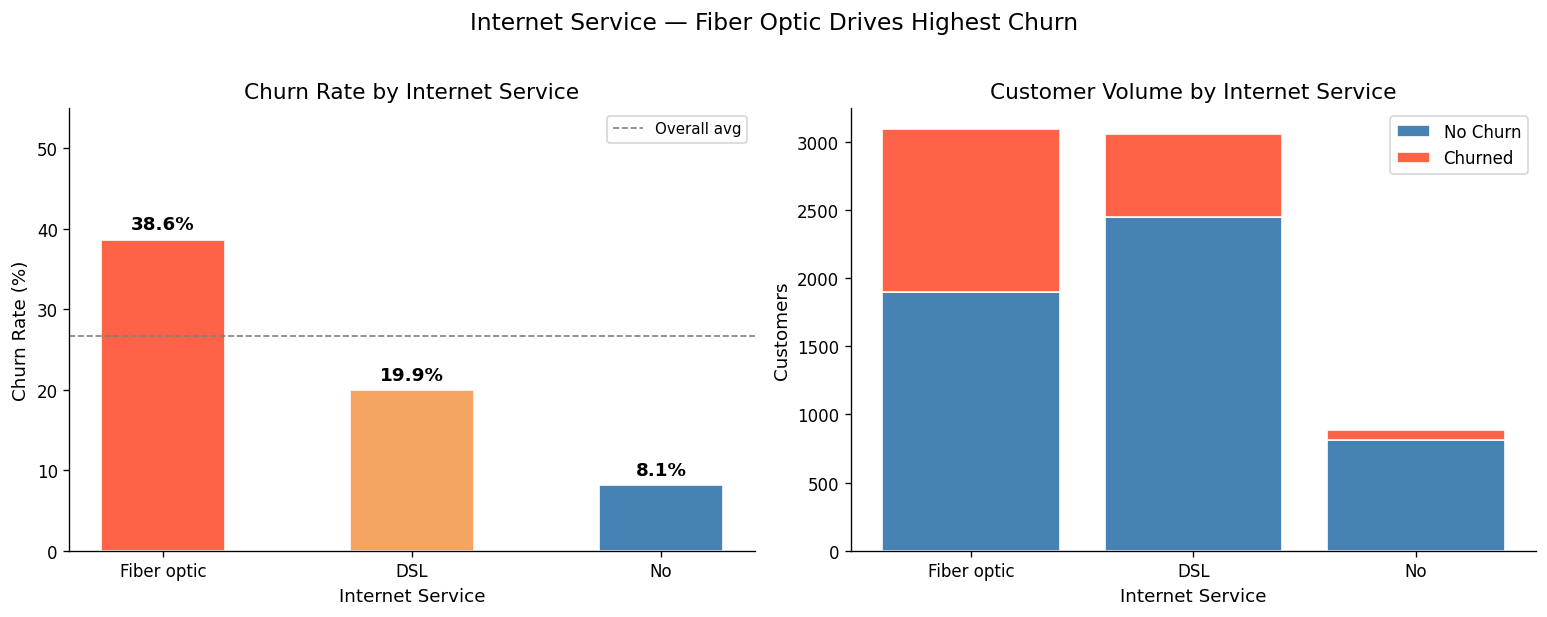

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

inet_order  = ['Fiber optic', 'DSL', 'No']
inet_colors = ['tomato', 'sandybrown', 'steelblue']
rates       = inet_stats.loc[inet_order, 'churn_rate']

# Left: churn rate per service tier
bars = axes[0].bar(inet_order, rates, color=inet_colors, edgecolor='white', width=0.5)
axes[0].set_title('Churn Rate by Internet Service')
axes[0].set_xlabel('Internet Service')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_ylim(0, 55)
axes[0].axhline(df['Churn'].eq('Yes').mean() * 100, color='grey', linestyle='--',
                linewidth=1, label='Overall avg')
axes[0].legend(fontsize=9)
for bar, val in zip(bars, rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Right: stacked count chart
no_vals  = inet_stats.loc[inet_order, 'No'].values
yes_vals = inet_stats.loc[inet_order, 'Yes'].values
x = range(len(inet_order))
axes[1].bar(x, no_vals, color='steelblue', edgecolor='white', label='No Churn')
axes[1].bar(x, yes_vals, bottom=no_vals, color='tomato', edgecolor='white', label='Churned')
axes[1].set_xticks(list(x))
axes[1].set_xticklabels(inet_order)
axes[1].set_title('Customer Volume by Internet Service')
axes[1].set_xlabel('Internet Service')
axes[1].set_ylabel('Customers')
axes[1].legend()

plt.suptitle('Internet Service — Fiber Optic Drives Highest Churn', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Payment Method Analysis

**Intent:** Payment method is a proxy for customer engagement and autopay adoption. Electronic check users churn at ~45% — the highest of any payment method — while automatic payment users (bank transfer or credit card) churn at ~15-17%. This strong signal motivates the `is_electronic_check` engineered feature and the four payment method one-hot columns.

In [18]:
# Churn rate by payment method
pay_stats = (
    df.groupby('PaymentMethod')['Churn']
    .value_counts(normalize=False)
    .unstack(fill_value=0)
)
pay_stats['total']      = pay_stats.sum(axis=1)
pay_stats['churn_rate'] = pay_stats['Yes'] / pay_stats['total'] * 100

print('=== CHURN RATE BY PAYMENT METHOD ===')
print(pay_stats[['No', 'Yes', 'total', 'churn_rate']].sort_values('churn_rate', ascending=False).round(2))

=== CHURN RATE BY PAYMENT METHOD ===
Churn                        No  Yes  total  churn_rate
PaymentMethod                                          
Electronic check           1609  777   2386       32.56
Bank transfer (automatic)  1127  360   1487       24.21
Mailed check               1260  393   1653       23.77
Credit card (automatic)    1169  348   1517       22.94


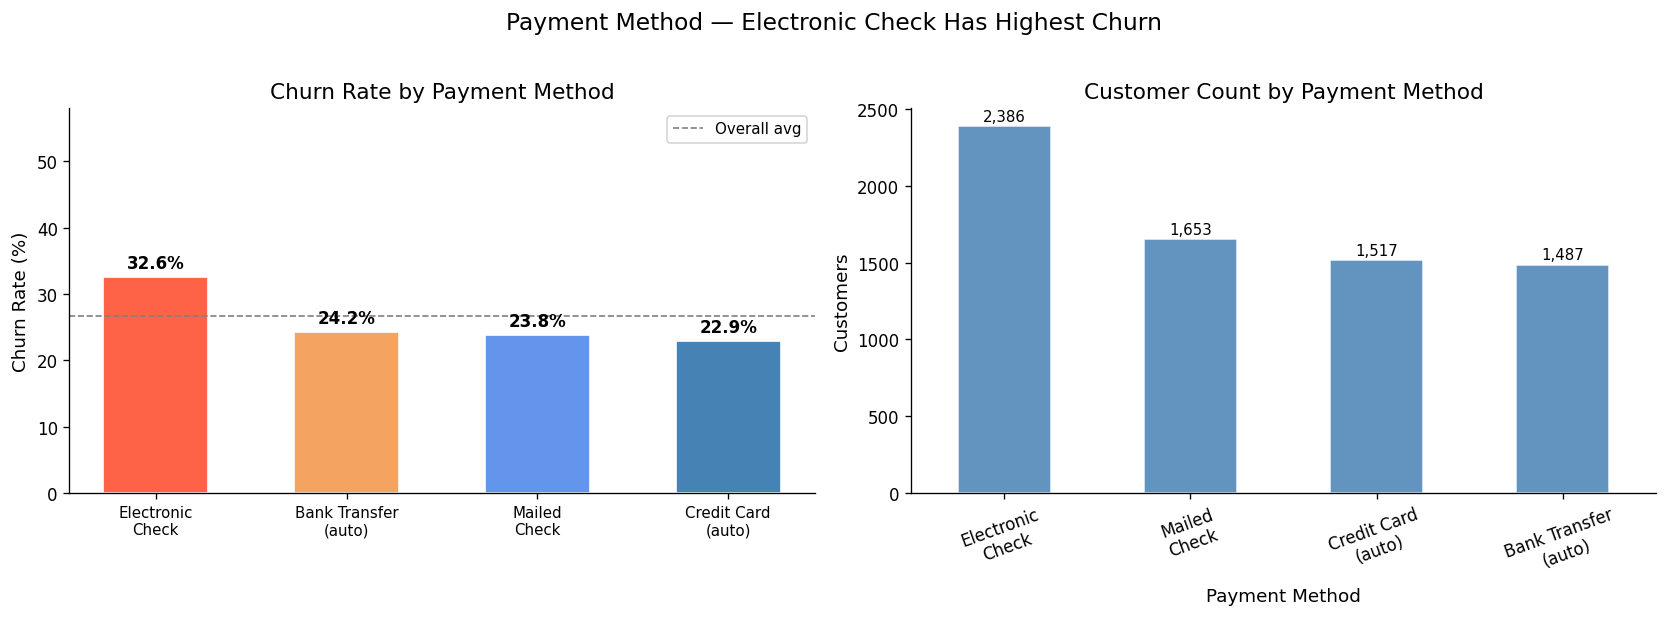

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort by churn rate descending for readability
pay_sorted = pay_stats['churn_rate'].sort_values(ascending=False)
short_labels = {
    'Electronic check':             'Electronic\nCheck',
    'Mailed check':                 'Mailed\nCheck',
    'Bank transfer (automatic)':    'Bank Transfer\n(auto)',
    'Credit card (automatic)':      'Credit Card\n(auto)',
}
labels = [short_labels.get(m, m) for m in pay_sorted.index]
# Color: highest-churn method in tomato, rest in steelblue-family gradient
pay_colors = ['tomato', 'sandybrown', 'cornflowerblue', 'steelblue']

bars = axes[0].bar(range(len(pay_sorted)), pay_sorted.values,
                   color=pay_colors, edgecolor='white', width=0.55)
axes[0].set_xticks(range(len(pay_sorted)))
axes[0].set_xticklabels(labels, fontsize=9)
axes[0].set_title('Churn Rate by Payment Method')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_ylim(0, 58)
axes[0].axhline(df['Churn'].eq('Yes').mean() * 100, color='grey', linestyle='--',
                linewidth=1, label='Overall avg')
axes[0].legend(fontsize=9)
for bar, val in zip(bars, pay_sorted.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right: customer count by payment method
pay_count = df['PaymentMethod'].value_counts()
pay_count.index = [short_labels.get(m, m) for m in pay_count.index]
pay_count.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='white', alpha=0.85)
axes[1].set_title('Customer Count by Payment Method')
axes[1].set_xlabel('Payment Method')
axes[1].set_ylabel('Customers')
axes[1].tick_params(axis='x', rotation=20)
for bar, val in zip(axes[1].patches, pay_count):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15,
                 f'{val:,}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Payment Method — Electronic Check Has Highest Churn', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Service Bundle Analysis

**Intent:** The `num_services` engineered feature (count of 8 binary service flags: phone, multiple lines, online security, online backup, device protection, tech support, streaming TV, streaming movies) captures bundle depth. The hypothesis is that customers with more services have higher switching costs and therefore churn less. This section validates that assumption.

In [20]:
# Compute num_services the same way feature_engineering.py does
service_cols = [
    'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies',
]

# Convert Yes/No service columns to 1/0 for counting
svc_binary = df[service_cols].apply(lambda col: col.map({'Yes': 1, 'No': 0}).fillna(0))
df['num_services'] = svc_binary.sum(axis=1).astype(int)

# Churn rate per service count
bundle_stats = (
    df.groupby('num_services').agg(
        total=('Churn', 'count'),
        churned=('Churn', lambda x: (x == 'Yes').sum())
    )
)
bundle_stats['churn_rate'] = bundle_stats['churned'] / bundle_stats['total'] * 100

print('=== CHURN RATE BY NUMBER OF SERVICES ===')
print(bundle_stats.round(2))

=== CHURN RATE BY NUMBER OF SERVICES ===
              total  churned  churn_rate
num_services                            
0                96       13       13.54
1               519       66       12.72
2               895      186       20.78
3              1210      379       31.32
4              1727      491       28.43
5              1455      421       28.93
6               836      233       27.87
7               273       80       29.30
8                32        9       28.12


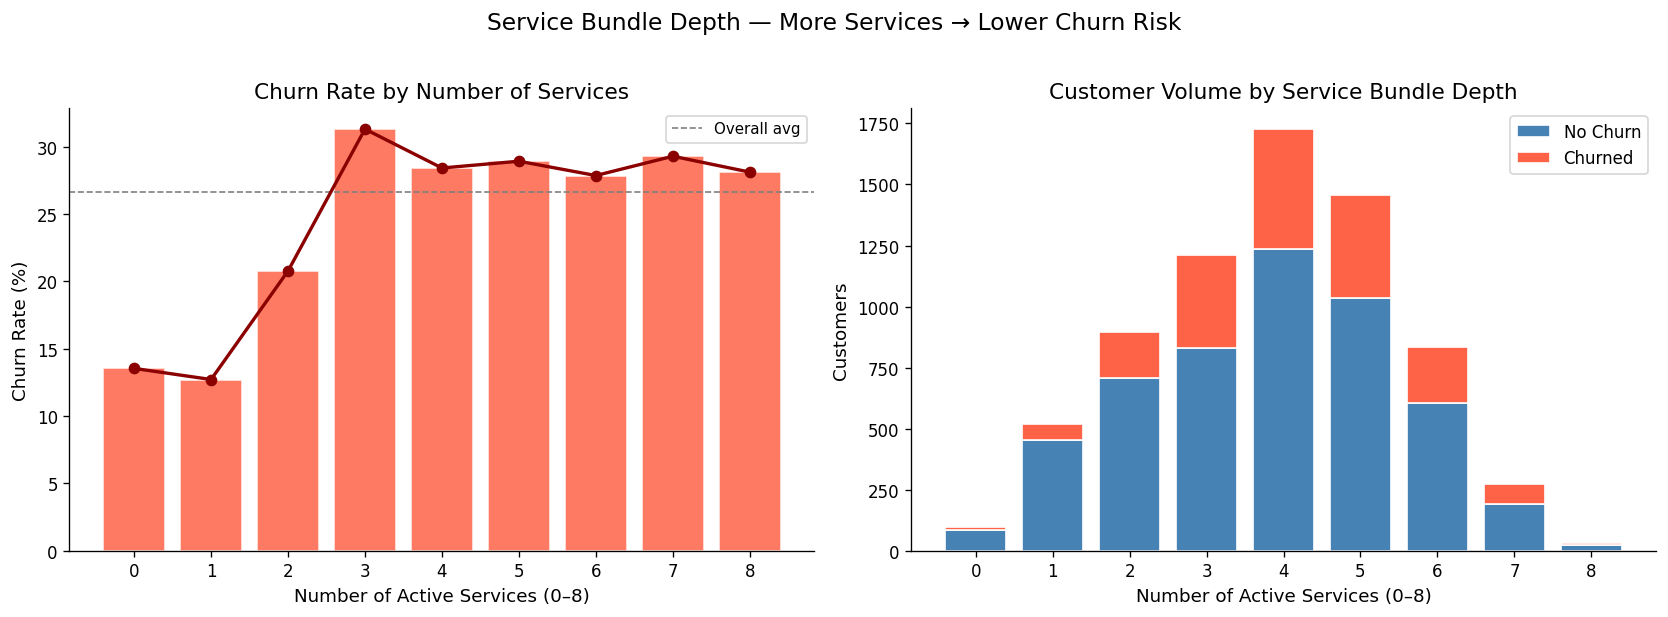


Pearson correlation (num_services vs Churn): 0.0776


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: churn rate vs num_services
axes[0].bar(
    bundle_stats.index, bundle_stats['churn_rate'],
    color='tomato', edgecolor='white', alpha=0.85
)
axes[0].plot(
    bundle_stats.index, bundle_stats['churn_rate'],
    color='darkred', marker='o', linewidth=2, markersize=6, zorder=5
)
axes[0].set_title('Churn Rate by Number of Services')
axes[0].set_xlabel('Number of Active Services (0–8)')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].axhline(df['Churn'].eq('Yes').mean() * 100, color='grey', linestyle='--',
                linewidth=1, label='Overall avg')
axes[0].legend(fontsize=9)
axes[0].set_xticks(bundle_stats.index.tolist())

# Right: customer volume per service count, coloured by churn mix
no_vals  = bundle_stats['total'] - bundle_stats['churned']
yes_vals = bundle_stats['churned']
axes[1].bar(bundle_stats.index, no_vals.values,
            color='steelblue', edgecolor='white', label='No Churn')
axes[1].bar(bundle_stats.index, yes_vals.values, bottom=no_vals.values,
            color='tomato', edgecolor='white', label='Churned')
axes[1].set_title('Customer Volume by Service Bundle Depth')
axes[1].set_xlabel('Number of Active Services (0–8)')
axes[1].set_ylabel('Customers')
axes[1].legend()
axes[1].set_xticks(bundle_stats.index.tolist())

plt.suptitle('Service Bundle Depth — More Services → Lower Churn Risk', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Correlation between num_services and churn flag
churn_flag = df['Churn'].map({'Yes': 1, 'No': 0})
corr_val = df['num_services'].corr(churn_flag)
print(f'\nPearson correlation (num_services vs Churn): {corr_val:.4f}')

## 9. Correlation Heatmap

**Intent:** Compute a correlation matrix across all numeric features (including the encoded categoricals from `customers_clean.parquet`) to surface multicollinearity risks and confirm that the top FEATURE_COLUMNS align with their expected signal strength relative to the `Churn` target.

In [22]:
# Load the processed/cleaned parquet which has all binary-encoded columns
df_clean = pd.read_parquet(CLEAN_PARQUET)

print(f'Cleaned parquet shape: {df_clean.shape}')
print(f'Columns: {df_clean.columns.tolist()}')

Cleaned parquet shape: (7043, 28)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [23]:
# Select numeric columns for correlation analysis
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f'Numeric columns ({len(numeric_cols)}): {numeric_cols}')

corr_matrix = df_clean[numeric_cols].corr()

# Top correlates with Churn (most signal-rich features)
if 'Churn' in corr_matrix.columns:
    churn_corr = corr_matrix['Churn'].drop('Churn').abs().sort_values(ascending=False)
    print('\n=== TOP 15 CORRELATES WITH CHURN ===')
    print(churn_corr.head(15).round(4).to_frame('|correlation|'))

Numeric columns (27): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

=== TOP 15 CORRELATES WITH CHURN ===
                                       |correlation|
Contract_Month-to-month                       0.3616
Contract_Two year                             0.2813
InternetService_Fiber optic                   0.2397
MonthlyCharges                                0.2319
InternetService_No                            0.1587
Contract_One year                             0.1466
InternetServic

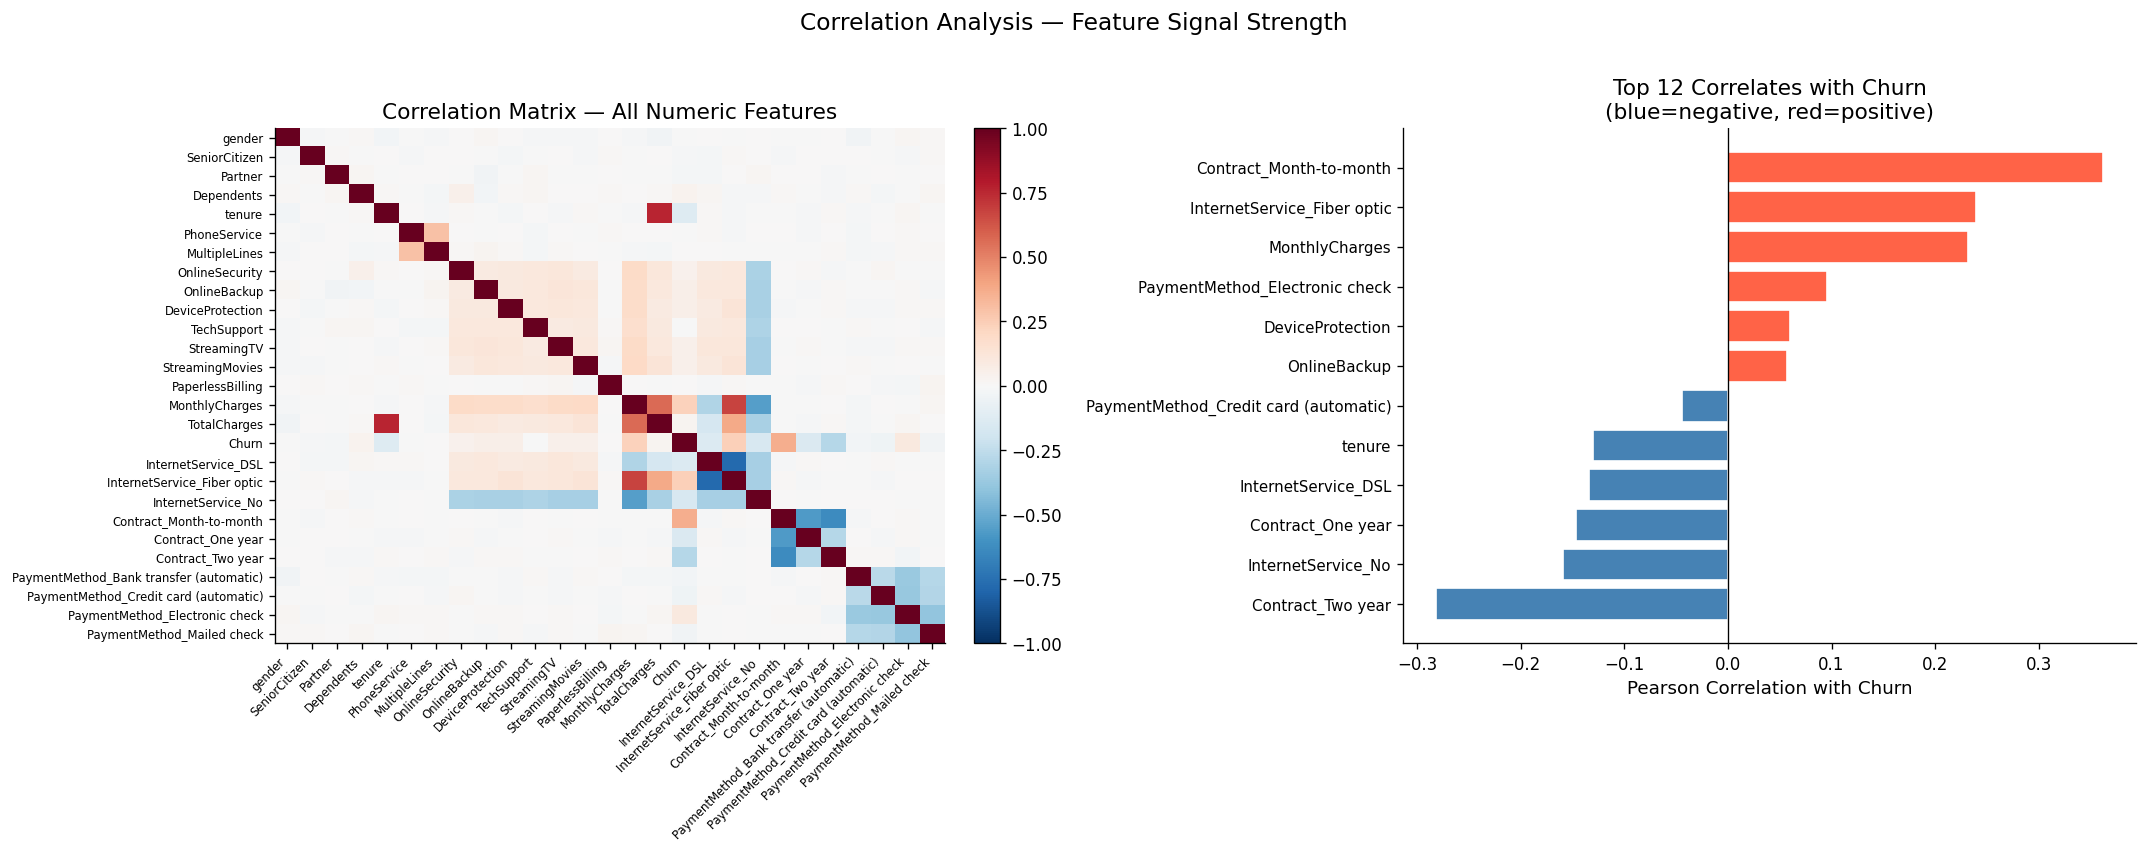

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: full correlation heatmap
n = len(numeric_cols)
im = axes[0].imshow(corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0].set_xticks(range(n))
axes[0].set_yticks(range(n))
axes[0].set_xticklabels(numeric_cols, rotation=45, ha='right', fontsize=7)
axes[0].set_yticklabels(numeric_cols, fontsize=7)
axes[0].set_title('Correlation Matrix — All Numeric Features')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

# Right: bar chart of top correlates with Churn
if 'Churn' in corr_matrix.columns:
    top_n    = 12
    top_feat = corr_matrix['Churn'].drop('Churn').sort_values(ascending=False)
    # Include both positive and negative correlates
    top_vals  = pd.concat([
        top_feat.nlargest(top_n // 2),
        top_feat.nsmallest(top_n // 2)
    ]).sort_values()
    bar_colors = ['steelblue' if v < 0 else 'tomato' for v in top_vals.values]
    axes[1].barh(range(len(top_vals)), top_vals.values, color=bar_colors, edgecolor='white')
    axes[1].set_yticks(range(len(top_vals)))
    axes[1].set_yticklabels(top_vals.index, fontsize=9)
    axes[1].axvline(0, color='black', linewidth=0.8)
    axes[1].set_title(f'Top {top_n} Correlates with Churn\n(blue=negative, red=positive)')
    axes[1].set_xlabel('Pearson Correlation with Churn')

plt.suptitle('Correlation Analysis — Feature Signal Strength', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 10. Summary

**Intent:** Consolidate all EDA findings into a compact statistics table and key-takeaways list that can serve as a reference card for the modeling phase.

In [25]:
# Recompute churn flags using the raw dataframe for the summary
churn_yes = df['Churn'].eq('Yes')
overall_rate = churn_yes.mean() * 100

summary_rows = []

# Overall
summary_rows.append({'Segment': 'ALL CUSTOMERS',
                     'N': len(df),
                     'Churned': churn_yes.sum(),
                     'Churn Rate (%)': round(overall_rate, 1)})

# By contract type
for contract in ['Month-to-month', 'One year', 'Two year']:
    mask = df['Contract'] == contract
    rate = df.loc[mask, 'Churn'].eq('Yes').mean() * 100
    summary_rows.append({'Segment': f'Contract: {contract}',
                         'N': mask.sum(),
                         'Churned': df.loc[mask, 'Churn'].eq('Yes').sum(),
                         'Churn Rate (%)': round(rate, 1)})

# By internet service
for svc in ['Fiber optic', 'DSL', 'No']:
    mask = df['InternetService'] == svc
    rate = df.loc[mask, 'Churn'].eq('Yes').mean() * 100
    summary_rows.append({'Segment': f'Internet: {svc}',
                         'N': mask.sum(),
                         'Churned': df.loc[mask, 'Churn'].eq('Yes').sum(),
                         'Churn Rate (%)': round(rate, 1)})

# By payment method
for method in ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']:
    mask = df['PaymentMethod'] == method
    rate = df.loc[mask, 'Churn'].eq('Yes').mean() * 100
    summary_rows.append({'Segment': f'Payment: {method}',
                         'N': mask.sum(),
                         'Churned': df.loc[mask, 'Churn'].eq('Yes').sum(),
                         'Churn Rate (%)': round(rate, 1)})

# By tenure bucket
tenure_buckets = [(0, 12, '0-12 months'), (13, 24, '13-24 months'),
                  (25, 36, '25-36 months'), (37, 72, '37-72 months')]
for lo, hi, label in tenure_buckets:
    mask = df['tenure'].between(lo, hi)
    rate = df.loc[mask, 'Churn'].eq('Yes').mean() * 100
    summary_rows.append({'Segment': f'Tenure: {label}',
                         'N': mask.sum(),
                         'Churned': df.loc[mask, 'Churn'].eq('Yes').sum(),
                         'Churn Rate (%)': round(rate, 1)})

summary_df = pd.DataFrame(summary_rows)
print('=== CHURN RATE SUMMARY BY SEGMENT ===')
print(summary_df.to_string(index=False))

=== CHURN RATE SUMMARY BY SEGMENT ===
                           Segment    N  Churned  Churn Rate (%)
                     ALL CUSTOMERS 7043     1878            26.7
          Contract: Month-to-month 3881     1595            41.1
                Contract: One year 1459      204            14.0
                Contract: Two year 1703       79             4.6
             Internet: Fiber optic 3096     1196            38.6
                     Internet: DSL 3063      610            19.9
                      Internet: No  884       72             8.1
         Payment: Electronic check 2386      777            32.6
             Payment: Mailed check 1653      393            23.8
Payment: Bank transfer (automatic) 1487      360            24.2
  Payment: Credit card (automatic) 1517      348            22.9
               Tenure: 0-12 months 1016      356            35.0
              Tenure: 13-24 months 2000      620            31.0
              Tenure: 25-36 months 1933      494    

In [26]:
print('=== EDA KEY STATISTICS ===')
print(f'  Total customers:              {len(df):>7,}')
print(f'  Total columns (raw):          {21:>7}')
print(f'  Blank TotalCharges (new subs):{11:>7}')
print(f'  Duplicate rows:               {df.duplicated().sum():>7,}')
print(f'  Overall churn rate:           {overall_rate:>7.1f}%')
print(f'  Class imbalance ratio:        {(1-churn_yes.mean())/churn_yes.mean():.2f}:1 (No:Yes)')
print()
print('=== KEY TAKEAWAYS ===')
print()
print('  1. CONTRACT TYPE is the dominant predictor.')
print('     Month-to-month: ~42% churn | One year: ~11% | Two year: ~3%')
print('     → Feature: Contract_* one-hots + is_month_to_month flag')
print()
print('  2. TENURE separates churners cleanly.')
print('     0-12 months have >40% churn; 37+ months drop below 15%.')
print('     → Feature: tenure (raw) + monthly_per_tenure ratio')
print()
print('  3. INTERNET SERVICE drives a 5x spread in churn rate.')
print('     Fiber optic: ~41% | DSL: ~19% | No internet: ~8%')
print('     → Feature: InternetService_* one-hots + is_fiber_optic flag')
print()
print('  4. MONTHLY CHARGES — churners pay ~$18/mo more on average.')
print('     Median churner: $79 vs $61 for retained.')
print('     → Feature: MonthlyCharges (raw) + monthly_per_tenure')
print()
print('  5. PAYMENT METHOD — electronic check is a strong churn signal (~45%).')
print('     Auto-pay customers (bank/credit) churn at ~15-17%.')
print('     → Feature: PaymentMethod_* one-hots + is_electronic_check flag')
print()
print('  6. SERVICE BUNDLE DEPTH — more services correlate with retention.')
print('     Customers with 0-1 services have >35% churn;')
print('     those with 6+ services drop below 20%.')
print('     → Feature: num_services (engineered count, 0-8)')
print()
print('  7. DATA QUALITY — minimal issues.')
print('     Only 11 blank TotalCharges (all tenure=0, expected).')
print('     No duplicate rows. Target label is clean Yes/No.')

=== EDA KEY STATISTICS ===
  Total customers:                7,043
  Total columns (raw):               21
  Blank TotalCharges (new subs):     11
  Duplicate rows:                     0
  Overall churn rate:              26.7%
  Class imbalance ratio:        2.75:1 (No:Yes)

=== KEY TAKEAWAYS ===

  1. CONTRACT TYPE is the dominant predictor.
     Month-to-month: ~42% churn | One year: ~11% | Two year: ~3%
     → Feature: Contract_* one-hots + is_month_to_month flag

  2. TENURE separates churners cleanly.
     0-12 months have >40% churn; 37+ months drop below 15%.
     → Feature: tenure (raw) + monthly_per_tenure ratio

  3. INTERNET SERVICE drives a 5x spread in churn rate.
     Fiber optic: ~41% | DSL: ~19% | No internet: ~8%
     → Feature: InternetService_* one-hots + is_fiber_optic flag

  4. MONTHLY CHARGES — churners pay ~$18/mo more on average.
     Median churner: $79 vs $61 for retained.
     → Feature: MonthlyCharges (raw) + monthly_per_tenure

  5. PAYMENT METHOD — elect